# Find the optimal lambda combinations
We have run the eq run with lambda=\[0.00 0.08 0.09 ... 0.92 1.00\]
with a given number of window, maximize the minimum overlap

In [1]:
import pandas as pd
from alchemtest.gmx import load_benzene
import alchemlyb
from alchemlyb.parsing.gmx import extract_u_nk
from alchemlyb.estimators import MBAR
from pathlib import Path
import numpy as np
import itertools
import time

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



/home/chui/Software-2023-04-11/miniconda3/envs/alchemlyb/lib/python3.12/site-packages/alchemlyb/estimators/mbar_.py:106: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  (len(groups.get_group(i)) if i in groups.groups else 0)

******* JAX 64-bit mode is now on! *******
*     JAX is now set to 64-bit mode!     *
*   This MAY cause problems with other   *
*      uses of JAX in the same code.     *
******************************************

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated CUDA installation found.
Version JAX was built against: 11080
Minimum supported: 12010
Installed version: 11080
The local installation version must be no lower than 12010.
--------------------------------------------------
Outdated cuBLAS installation found.
Version JAX was built against: 

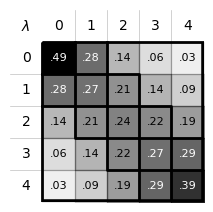

In [2]:
# Tutorial from https://alchemlyb.readthedocs.io/en/latest/visualisation.html
bz = load_benzene().data
u_nk_coul = alchemlyb.concat([extract_u_nk(xvg, T=300) for xvg in bz['Coulomb']])
mbar_coul = MBAR()
mbar_coul.fit(u_nk_coul)
from alchemlyb.visualisation import plot_mbar_overlap_matrix
ax = plot_mbar_overlap_matrix(mbar_coul.overlap_matrix)
# ax.figure.savefig('O_MBAR.pdf', bbox_inches='tight', pad_inches=0.0)

In [3]:
u_nk_coul

,,0.0,0.25,0.5,0.75,1.0
time,fep-lambda,,,,,
0.0,0.0,0.309323,3.656838,7.004353,10.351867,13.699382
10.0,0.0,0.308844,2.616688,4.924532,7.232375,9.540219
20.0,0.0,0.300940,1.626739,2.952538,4.278337,5.604135
30.0,0.0,0.309712,1.579647,2.849583,4.119518,5.389453
40.0,0.0,0.299979,2.255386,4.210794,6.166202,8.121609
...,...,...,...,...,...,...
39960.0,1.0,3.913593,3.011197,2.108801,1.206405,0.304009
39970.0,1.0,-0.365724,-0.197390,-0.029055,0.139279,0.307614
39980.0,1.0,1.495407,1.199280,0.903152,0.607024,0.310897


In [4]:


def get_merged_overlap_matrix(base_res, T, drop = 9):
    xvg_list = [base_res / f"0/Lambda_{i}/md.xvg" for i in range(64)]
    u_nk0 = alchemlyb.concat([extract_u_nk(xvg, T=T) for xvg in xvg_list])
    mbar_all0 = MBAR()
    mbar_all0.fit(u_nk0)
    o_matrix0 = mbar_all0.overlap_matrix
    
    xvg_list = [base_res / f"1/Lambda_{i}/md.xvg" for i in range(64)]
    u_nk1 = alchemlyb.concat([extract_u_nk(xvg, T=T) for xvg in xvg_list])
    mbar_all1 = MBAR()
    mbar_all1.fit(u_nk1)
    o_matrix1 = mbar_all1.overlap_matrix
    
    l_list0    = "0.00 0.08 0.09 0.10 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.20 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.30 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.40 0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.50 0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.60 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.70"
    l_list0    = [float(i) for i in l_list0.split()]
    l_list1    = "0.30 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.40 0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.50 0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.60 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.70 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.80 0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.90 0.91 0.92 1.00"
    l_list1    = [float(i) for i in l_list1.split()]
    l_list_all = "0.00 0.08 0.09 0.10 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.20 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.30 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.40 0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.50 0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.60 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.70 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.80 0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.90 0.91 0.92 1.00"
    l_list_all = [float(i) for i in l_list_all.split()]
    
    o_all = np.zeros((len(l_list_all), len(l_list_all)))
    
    l0 = len(l_list0)
    l1 = len(l_list1)
    lall = len(l_list_all)
    
    o_all[0:l0 -drop, 0:l0 -drop] = o_matrix0[:-drop, :-drop]
    o_all[-l1 +drop:, -l1+drop:] = o_matrix1[drop:, drop:]
    
    o_middle = (o_matrix0[lall - l1 + drop:-drop, lall - l1 + drop:-drop] + o_matrix1[drop:-(lall - l0)-drop, drop:-(lall - l0)-drop]) / 2
    o_all[-l1 +drop : l0 -drop, -l1 +drop : l0 -drop] = o_middle
        
    return o_all




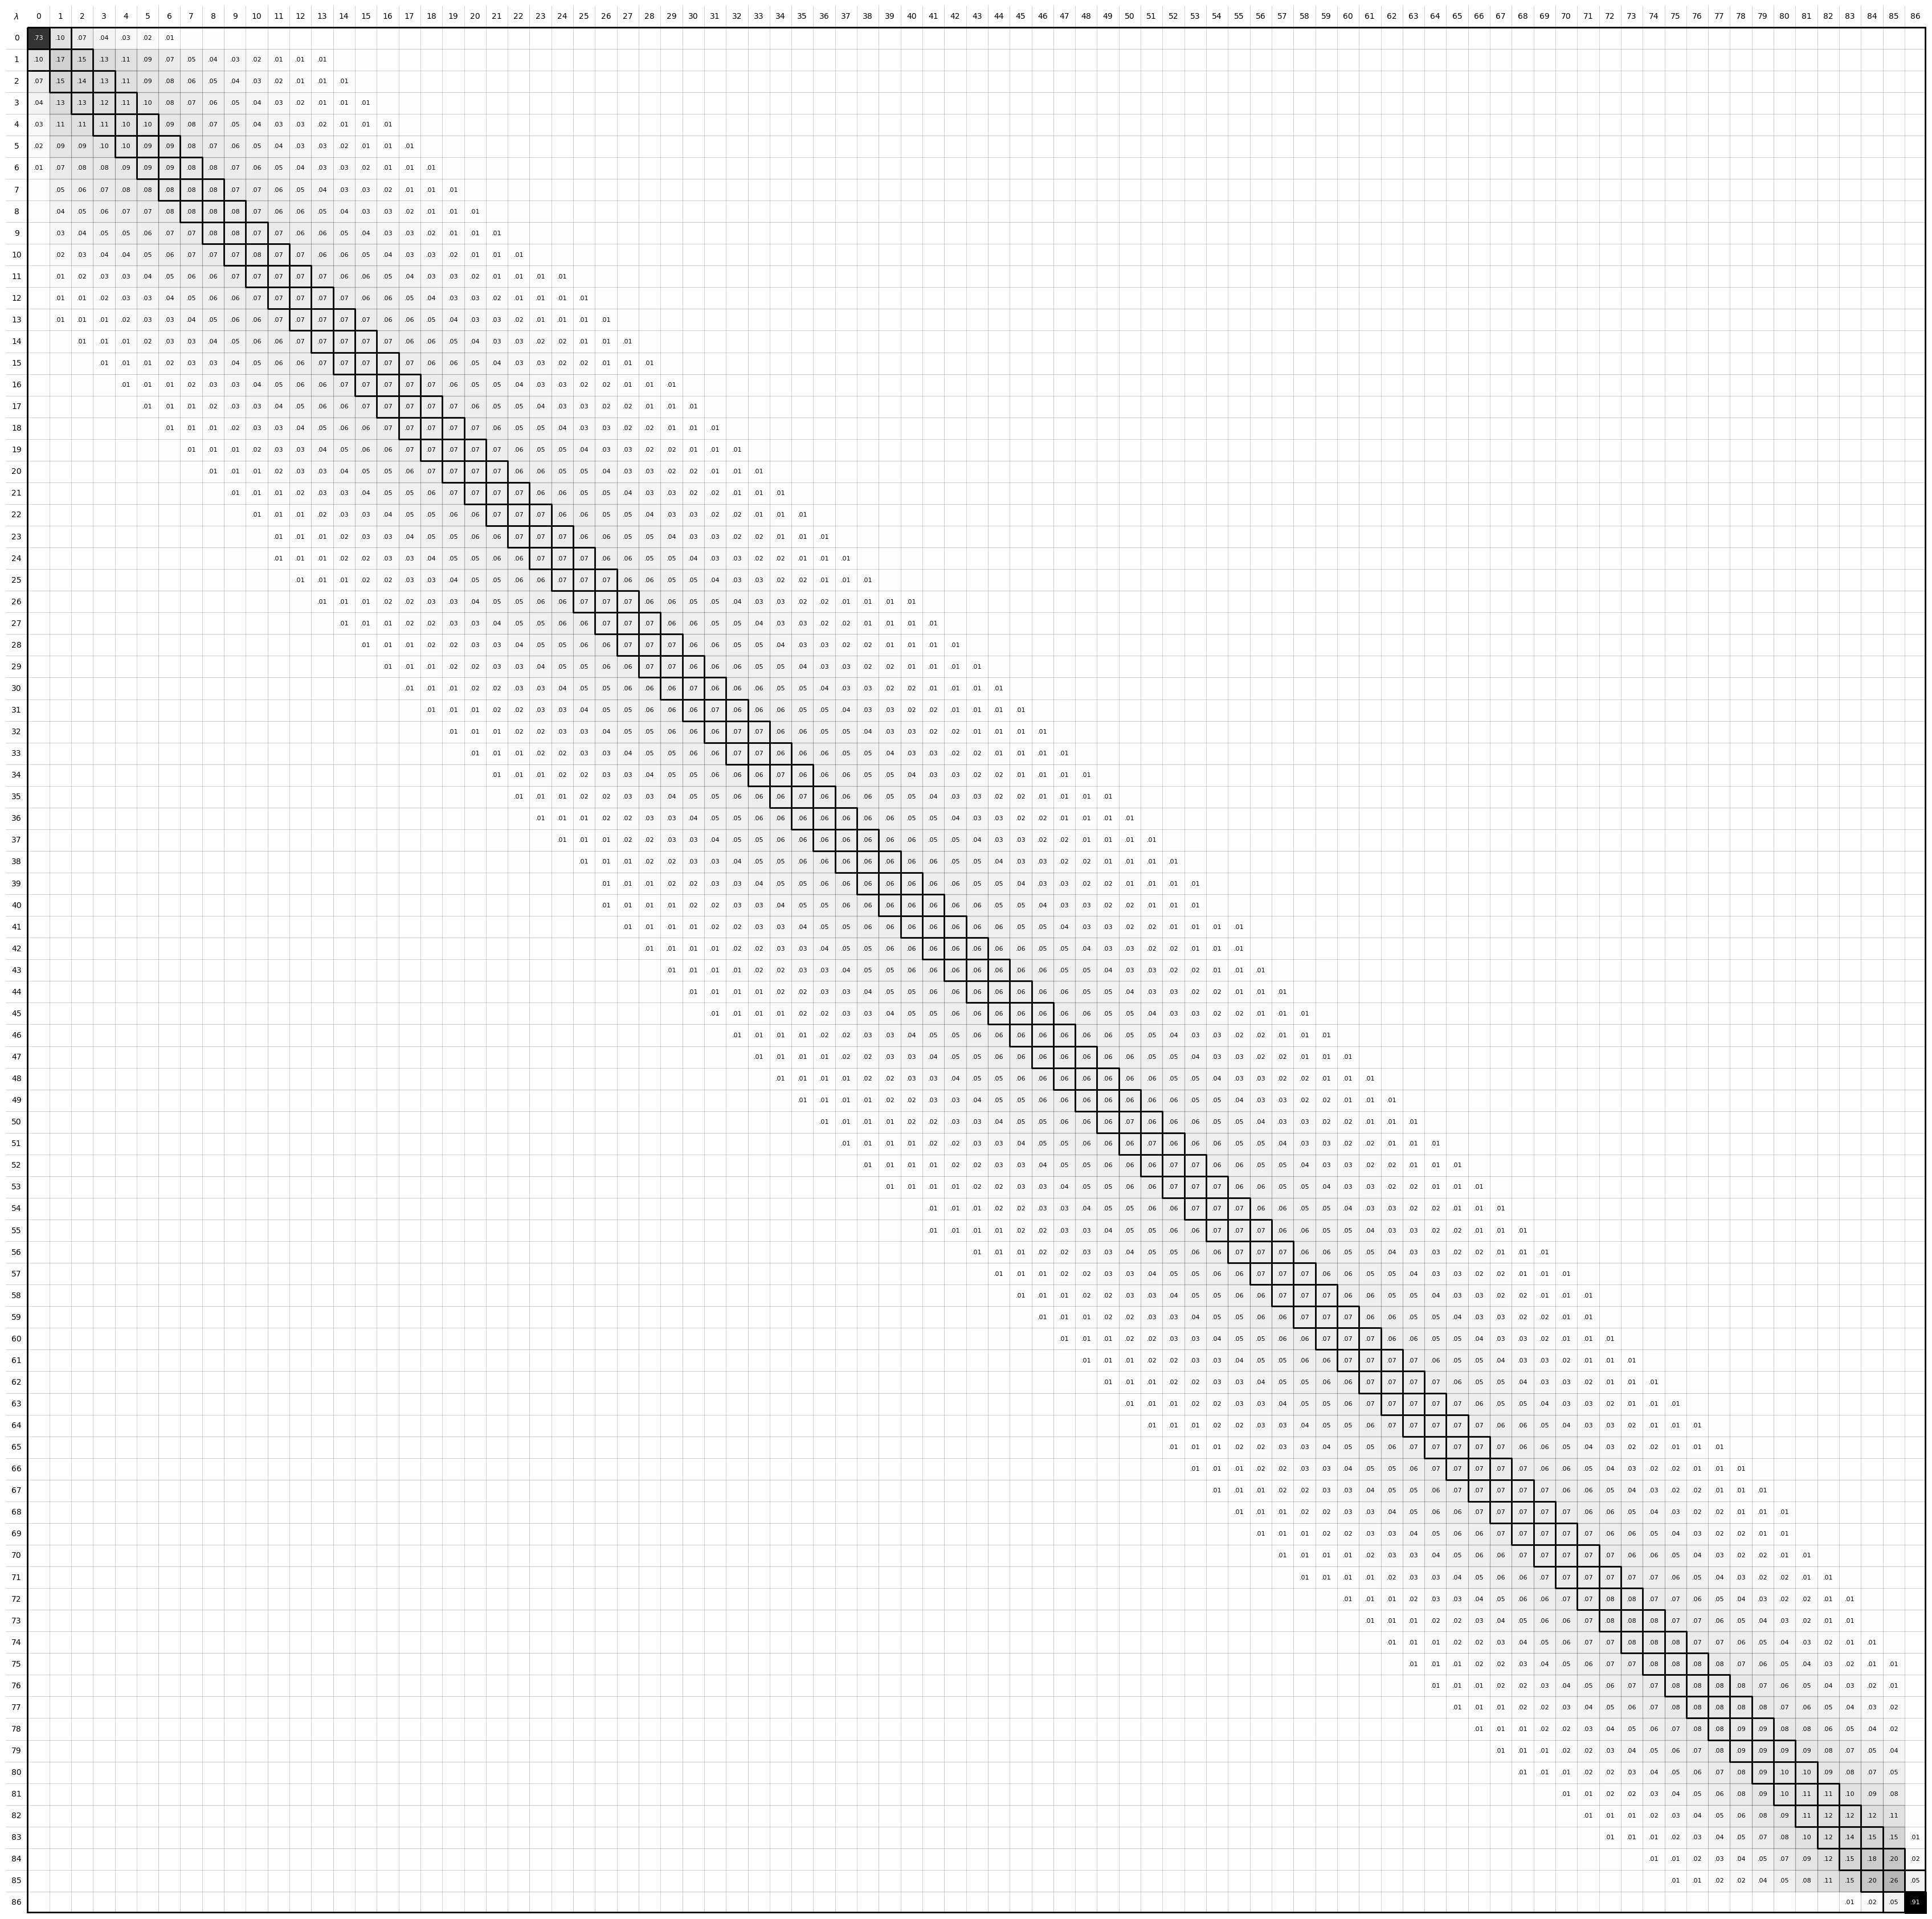

In [7]:
base     = Path("../../../")
base_res = base/"ASP-CYM/03-HRE/run_1/01-L_opt/"
o_all = get_merged_overlap_matrix(base_res, T=298, drop = 9)
ax = plot_mbar_overlap_matrix(o_all)

In [8]:
def find_l_combination(overlap_matrix, n_win):
    """
    with a given overlap_matrix and number of lambda window, maximize the minimum value in a overlap_matrix
    Test all the combinations
    """
    pass

    max_comb = []
    min_over = 0
    overlap_map = overlap_matrix>min_over
    # Create a list of numbers. We fix the start and end, only need to generate n_win-2
    numbers = list(range(1, overlap_matrix.shape[0]))
    for combi in itertools.combinations(numbers, n_win-2):
        if (not overlap_map[0, combi[0]]) or (not overlap_map[-1, combi[-1]]):
            continue
        combi_tmp = np.array([0] + list(combi) + [overlap_matrix.shape[0]-1])
        min_over_tmp = np.min(overlap_matrix[combi_tmp[:-1], combi_tmp[1:]])
        if min_over_tmp > min_over:
            max_comb = combi_tmp
            min_over = min_over_tmp
            overlap_map = overlap_matrix>min_over
    return max_comb, min_over


def find_l_greedy(overlap_matrix, overlap_cutoff):
    """
    start from 0 and 1, use greedy alg to find a path
    """
    path_0 = [0]
    path_1 = [overlap_matrix.shape[0]-1]
    path_all = path_0 + path_1[::-1]
    min_over = np.min(overlap_matrix[path_all[:-1], path_all[1:]])
    
    while min_over < overlap_cutoff:
        if len(path_0) <= len(path_1):
            # print("head")
            for i in range(path_1[-1]-1, path_0[-1], -1):
                if overlap_matrix[path_0[-1], i] > overlap_cutoff:
                    path_0.append(i)
                    break
        else:
            # print("tail")
            for i in range(path_0[-1]+1, path_1[-1]):
                if overlap_matrix[path_1[-1], i] > overlap_cutoff:
                    path_1.append(i)
                    break
        path_all = path_0 + path_1[::-1]
        # print(path_all)
        min_over = np.min(overlap_matrix[path_all[:-1], path_all[1:]])
            
    return path_all, min_over








In [9]:
n = 5
o_test = np.zeros((n, n))
o_test[range(n), range(n)] = 1
o_test[range(1,n), range(n-1)] = 0.5
o_test[range(n-1), range(1,n)] = 0.5

o_test[range(2,n), range(n-2)] = 0.4
o_test[range(n-2), range(2,n)] = 0.4
print(o_test)
print(find_l_greedy(o_test, 0.49))
print(find_l_greedy(o_test, 0.39))

[[1.  0.5 0.4 0.  0. ]
 [0.5 1.  0.5 0.4 0. ]
 [0.4 0.5 1.  0.5 0.4]
 [0.  0.4 0.5 1.  0.5]
 [0.  0.  0.4 0.5 1. ]]
([0, 1, 2, 3, 4], 0.5)
([0, 2, 4], 0.4)


In [10]:

def find_l_path_greedy(overlap_matrix, i0=1e-7):
    """
    use greedy alg to find the lambda path.
    we iterativly increase the overlap threshold until overlap_term. For each number of window, only the best lambda path will be recorded.
    overlap_matrix:
    i0            : initial overlap threshold
    return
        lambda_dict
            key  , number of window
            value, [min_over, path_all]
    """
    i = i0
    lambda_dict = {}
    path_all = []
    overlap_term = min(overlap_matrix[range(overlap_matrix.shape[0]-1),range(1, overlap_matrix.shape[0])]) # first-off-diagonal elements
    while i<overlap_term and len(path_all) < overlap_matrix.shape[0]-2:
        path_all, min_over = find_l_greedy(overlap_matrix, i)
        if len(path_all) not in lambda_dict or min_over > lambda_dict[len(path_all)][0]:
            lambda_dict[len(path_all)] = [min_over, path_all]
        # print(f"{len(path_all):2d} {min_over : .4e}", path_all)
        i = min_over * (1.0 + 1e-4)
    # lambda_dict.pop(max(lambda_dict.keys())) # this one is not reliable
    return lambda_dict

In [12]:
lambda_dict = find_l_path_greedy(o_all)
for i, (min_over, path_all) in lambda_dict.items():
    print(f"{len(path_all):2d} {min_over : .4e}", path_all)

 5  1.0806e-06 [0, 18, 47, 74, 86]
 6  6.5077e-05 [0, 13, 35, 58, 78, 86]
 7  4.9312e-04 [0, 10, 28, 47, 65, 81, 86]
 8  2.1347e-03 [0, 8, 22, 38, 54, 69, 82, 86]
 9  4.8425e-03 [0, 7, 19, 32, 46, 59, 72, 83, 86]
10  9.0114e-03 [0, 5, 16, 27, 39, 51, 63, 74, 83, 86]
11  1.3083e-02 [0, 5, 15, 25, 36, 47, 57, 67, 76, 84, 86]
12  1.7763e-02 [0, 4, 13, 22, 31, 41, 50, 59, 68, 77, 84, 86]
13  2.2523e-02 [0, 4, 12, 20, 28, 37, 46, 53, 61, 69, 77, 84, 86]
14  2.6513e-02 [0, 3, 11, 18, 25, 33, 41, 49, 57, 65, 72, 79, 85, 86]
15  3.1945e-02 [0, 3, 10, 17, 24, 31, 38, 45, 52, 59, 66, 73, 79, 85, 86]
16  3.4025e-02 [0, 3, 10, 16, 22, 28, 35, 42, 49, 55, 61, 67, 73, 79, 85, 86]
17  4.0049e-02 [0, 3, 9, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 80, 85, 86]
18  4.0352e-02 [0, 3, 9, 14, 20, 25, 31, 37, 42, 48, 53, 59, 65, 70, 75, 80, 85, 86]
19  4.0539e-02 [0, 3, 9, 14, 19, 24, 29, 35, 40, 46, 50, 55, 60, 65, 70, 75, 80, 85, 86]
20  4.6811e-02 [0, 2, 8, 13, 18, 23, 28, 33, 38, 42, 47, 51, 55, 60, 6

In [13]:
# tick = time.time()
# for i in range(3,8):
#     max_comb, min_over = find_l_combination(overlap_matrix, i, )
#     
#     tock = time.time()
#     print(f"{i} time={tock-tick:6.1f} s, {min(overlap_matrix[max_comb[:-1], max_comb[1:]]) : .4e}", max_comb)
#     tick = tock

### Sample output for testing. Exact solution with full combination loop over scales badly
```
3 time=   0.0 s,  1.2631e-19 [ 0 46 86]
4 time=   0.0 s,  1.5569e-12 [ 0 32 61 86]
5 time=   0.3 s,  1.0806e-06 [ 0 18 47 74 86]
6 time=   5.2 s,  6.5077e-05 [ 0 13 35 58 78 86]
7 time=  76.7 s,  4.9312e-04 [ 0 10 28 47 65 81 86]
8 time= 982.7 s,  2.1347e-03 [ 0  8 22 38 54 69 82 86]
```

# Finally, all of the functions have been written.
analysis start from here

In [83]:
base     = Path("../../../")
T = 298.15
l_list_all = "0.00 0.08 0.09 0.10 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.20 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.30 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.40 0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.50 0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.60 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.70 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.80 0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.90 0.91 0.92 1.00"
l_list_all = l_list_all.split()
len(l_list_all)

87

In [21]:
all_res = {}
for base_res in base.glob("???-???/"):
    print(base_res, end=" MBAR... ")
    base_res_opt = base_res / "03-HRE/run_1/01-L_opt/"
    o_all = get_merged_overlap_matrix(base_res_opt, T, drop = 9)
    np.save(base_res_opt/'overlap_matrix.npy', o_all)
    
    print("find path...", end = " ")
    lambda_dict = find_l_path_greedy(o_all)
    print("Done. ")
    
    lines = []
    for i, (min_over, path_all) in lambda_dict.items():
        l_list = [l_list_all[i] for i in path_all]
        lines.append(f"{len(path_all):2d}, {min_over : .7e}, " + " ".join(l_list) + "\n")
    with open(base_res_opt/"lambda_path.dat", "w") as f:
        f.writelines(lines)
    
    all_res[base_res.name] = lambda_dict
    # break

../../ASP-GLU MBAR... find path... Done. 
../../ASP-CYM MBAR... find path... Done. 
../../ASP-HSD MBAR... find path... Done. 
../../ASP-HSE MBAR... find path... Done. 
../../ASP-LSN MBAR... find path... Done. 
../../GLU-ASP MBAR... find path... Done. 
../../GLU-CYM MBAR... find path... Done. 
../../GLU-HSD MBAR... find path... Done. 
../../GLU-HSE MBAR... find path... Done. 
../../GLU-LSN MBAR... find path... Done. 
../../CYM-ASP MBAR... find path... Done. 
../../CYM-GLU MBAR... find path... Done. 
../../CYM-HSD MBAR... find path... Done. 
../../CYM-HSE MBAR... find path... Done. 
../../CYM-LSN MBAR... find path... Done. 
../../HSD-ASP MBAR... find path... Done. 
../../HSD-GLU MBAR... find path... Done. 
../../HSD-CYM MBAR... find path... Done. 
../../HSD-HSE MBAR... find path... Done. 
../../HSD-LSN MBAR... find path... Done. 
../../HSE-ASP MBAR... find path... Done. 
../../HSE-GLU MBAR... find path... Done. 
../../HSE-CYM MBAR... find path... Done. 
../../HSE-HSD MBAR... find path...

In [107]:
l_folder_map = {i:f"0/Lambda_{i}" for i in range(64-9)}
for i in range(87//2, 87):
    l_folder_map[i] = f"1/Lambda_{i-23}"
# l_folder_map
def write_gro_prepare(file, ind_list, l_folder_map, l_list_all):
    l_list = [l_list_all[i] for i in ind_list]
    lines = ["base=$PWD\n",
            f"for i in {{0..{len(ind_list)-1}}}\n",
             "do\n",
             "    cd $base\n",
             "    mkdir Lambda_$i\n",
             "    cd Lambda_$i\n",
             "    cp ../MDP/md.mdp ./\n",
             "    cat ../MDP/freeE_tmp.mdp >> md.mdp\n",
             "    sed -i \"s/LAMBDA_NUM/$i/g\" md.mdp\n",
            f"    echo \"coul-lambdas    = {"  ".join(l_list)}\" >> md.mdp\n"
            f"    echo \"vdw-lambdas     = {"  ".join(l_list)}\" >> md.mdp\n"
             "done\n",
             "cd $base\n"
            ]
    for win, i in enumerate(ind_list):
        lines += [f"cp ../../run_1/01-L_opt/{l_folder_map[i]}/md.gro ./Lambda_{win}/md_init.gro\n"]
    with open(file, "w") as f:
        f.writelines(lines)
        

In [108]:
target_overlap = 0.03
for name, lambda_dict in all_res.items():
    print(name)
    overlap_matrix = np.load(base/name/"03-HRE/run_1/01-L_opt/"/'overlap_matrix.npy')
    for i, (min_overlap, ind_list) in lambda_dict.items():
        # if min_overlap > target_overlap:
        if i == 16:
            l_list = [l_list_all[i] for i in ind_list]
            print(f"{i}, {min_overlap:.4f}, ", "  ".join(l_list))
            print("Overlap:       ", "  ".join([f"{i*100:4.2f}" for i in overlap_matrix[ind_list[:-1],ind_list[1:]]]), "   x 0.01")
            write_gro_prepare(base/name/"03-HRE/run_1/02-win16/prepare.sh", ind_list, l_folder_map, l_list_all)
            break

ASP-GLU
16, 0.0304,  0.00  0.08  0.13  0.19  0.25  0.32  0.39  0.46  0.53  0.60  0.67  0.74  0.80  0.86  0.92  1.00
Overlap:        4.51  4.64  3.63  3.91  3.14  3.27  3.39  3.39  3.34  3.30  3.21  3.79  3.72  3.04  3.72    x 0.01
ASP-CYM
16, 0.0340,  0.00  0.10  0.17  0.23  0.29  0.35  0.42  0.49  0.56  0.62  0.68  0.74  0.80  0.86  0.92  1.00
Overlap:        4.27  3.53  4.01  4.01  4.03  3.41  3.40  3.42  4.03  4.05  4.03  3.99  3.99  3.57  5.08    x 0.01
ASP-HSD
16, 0.0337,  0.00  0.09  0.15  0.21  0.27  0.33  0.40  0.47  0.54  0.61  0.68  0.74  0.80  0.86  0.92  1.00
Overlap:        4.08  4.52  3.88  4.01  4.04  3.42  3.41  3.46  3.41  3.37  4.03  4.01  4.01  3.52  5.66    x 0.01
ASP-HSE
16, 0.0340,  0.00  0.09  0.16  0.22  0.28  0.34  0.41  0.48  0.55  0.62  0.68  0.74  0.80  0.86  0.92  1.00
Overlap:        4.33  3.45  3.95  4.03  4.01  3.40  3.44  3.45  3.43  4.02  4.03  4.05  3.98  3.62  4.49    x 0.01
ASP-LSN
16, 0.0330,  0.00  0.09  0.15  0.21  0.27  0.34  0.41  0.48  0.55  0